In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['axes.formatter.useoffset'] = False
# Global font size settings
plt.rcParams['axes.titlesize'] = 18      # Title font size
plt.rcParams['axes.labelsize'] = 16      # X and Y axis labels
plt.rcParams['xtick.labelsize'] = 14     # X tick labels
plt.rcParams['ytick.labelsize'] = 14     # Y tick labels
plt.rcParams['legend.fontsize'] = 14     # Legend text
plt.rcParams['figure.titlesize'] = 18    # Figure title (if using `fig.suptitle`)

### Finding the Optimal Squeezing Phase via Gaussian Mixture Model (GMM) Analysis

- For each pump phase in the range $0^\circ$ to $175^\circ$ (step $5^\circ$), this cell:

  - Loads measured quadrature data from files for the **idler** mode ($x_i$) and **signal** mode ($x_s$).
  - Applies the vacuum-determined scaling factor $s$ to the signal data to normalize scales.
  - Stacks the scaled quadratures into a 2D dataset: $\mathbf{X} = (x_i, s \times x_s)$.
  - Fits a single-component Gaussian Mixture Model (GMM) to this dataset to estimate the covariance matrix and mean.
  - Computes the eigenvalues and eigenvectors of the covariance matrix to find principal axes and corresponding standard deviations (square roots of eigenvalues).
  - Tracks the minimum and maximum standard deviations (variances) for each phase.

- After iterating over all phases, it identifies:

  - The **optimal squeezing phase** as the phase with the smallest minimum standard deviation (most squeezed axis).
  - The phase with the largest maximum standard deviation (most anti-squeezed axis).

This process helps quantify the squeezing and anti-squeezing behavior of the two-mode state as a function of pump phase.


In [6]:
from sklearn.mixture import GaussianMixture
import numpy as np

# === Parameters ===
N = 40 * 20000
s = 1
phases = np.arange(0, 180, 5)

base_signal = "Idler/ch1_idler_data_fs=5.90000GHz_fi=6.55264GHz_fp=12.45264GHz_Pp=20_phase={:.1f}.dat"
base_idler  = "Signal/ch0_signal_data_fs=5.90000GHz_fi=6.55264GHz_fp=12.45264GHz_Pp=20_phase={:.1f}.dat"

variances_min = []
variances_max = []
results = []  # To store (mean, cov, eigvecs, std_devs) per phase

for phase in phases:
    try:
        signal_file = base_signal.format(phase)
        idler_file = base_idler.format(phase)

        I0_on, Q0_on, I0_off, Q0_off = np.fromfile(signal_file).reshape(4, N)
        I1_on, Q1_on, I1_off, Q1_off = np.fromfile(idler_file).reshape(4, N)

        data = np.column_stack((I1_on, I0_on * s))

        gmm = GaussianMixture(n_components=1, covariance_type='full', random_state=0)
        gmm.fit(data)

        mean = gmm.means_[0]
        cov = gmm.covariances_[0]
        eigvals, eigvecs = np.linalg.eigh(cov)
        std_devs = np.sqrt(eigvals)

        variances_min.append(np.min(std_devs))
        variances_max.append(np.max(std_devs))

        results.append((mean, cov, eigvecs, std_devs))

    except FileNotFoundError:
        print(f"Warning: Missing file for phase {phase:.1f}° — skipped.")
        variances_min.append(np.nan)
        variances_max.append(np.nan)
        results.append((None, None, None, None))

valid_indices = ~np.isnan(variances_min)
filtered_phases = phases[valid_indices]
filtered_min_vars = np.array(variances_min)[valid_indices]
filtered_max_vars = np.array(variances_max)[valid_indices]
filtered_results = [results[i] for i, valid in enumerate(valid_indices) if valid]

optimal_index = np.argmin(filtered_min_vars)
optimal_phase = filtered_phases[optimal_index]
min_variance = filtered_min_vars[optimal_index]

max_index = np.argmax(filtered_max_vars)
max_phase = filtered_phases[max_index]
max_variance = filtered_max_vars[max_index]

print(f"Optimal squeezing phase (min variance): {optimal_phase} degrees")
print(f"Minimum variance (std dev) at this phase: {min_variance:.3f}")
print(f"Phase with maximum variance: {max_phase} degrees")
print(f"Maximum variance (std dev) at this phase: {max_variance:.3f}")

# Extract the results for the optimal phase
mean, cov, eigvecs, std_devs = filtered_results[optimal_index]

print(f"\nResults at optimal squeezing angle ({optimal_phase} degrees):")
print("Mean:", mean)
print("Covariance matrix:\n", cov)
print("Principal axes (eigenvectors):\n", eigvecs)
print("Principal axis standard deviations:", std_devs)


Optimal squeezing phase (min variance): 145 degrees
Minimum variance (std dev) at this phase: 9.418
Phase with maximum variance: 155 degrees
Maximum variance (std dev) at this phase: 21.921

Results at optimal squeezing angle (145 degrees):
Mean: [-1.10847819e-03 -2.74353029e+00]
Covariance matrix:
 [[ 224.65348247 -185.15658694]
 [-185.15658694  340.84439815]]
Principal axes (eigenvectors):
 [[-0.80603147 -0.59187268]
 [-0.59187268  0.80603147]]
Principal axis standard deviations: [ 9.41765015 21.83588208]


### Estimate Scale Factor from Vacuum State (Pump-Off Data)

This cell stacks the vacuum (pump-off) quadrature data for the two modes — $I_1$ (idler, $x_i$) and $I_0$ (signal, $x_s$) — into a single dataset.

A Gaussian Mixture Model (GMM) with one component is fitted to this vacuum data to extract the covariance matrix.

The variances along each quadrature axis ($x_i$ and $x_s$) are obtained from the diagonal of the covariance matrix.

Finally, the scale factor $s$ is calculated as the square root of the ratio of these variances:

$$
s = \sqrt{\frac{\mathrm{var}(x_i)}{\mathrm{var}(x_s)}}
$$

which normalizes the vacuum cloud to be circular. This scaling factor can then be applied when analyzing the squeezed state data.


In [7]:
# Stack vacuum (pump-off) data: (I1, I0)
vacuum_data = np.column_stack((I1_off, I0_off))  # xi vs xs

# Fit GMM to vacuum
gmm_vac = GaussianMixture(n_components=1, covariance_type='full', random_state=0)
gmm_vac.fit(vacuum_data)
cov_vac = gmm_vac.covariances_[0]

# Extract raw variances
var_xi_vac = cov_vac[0, 0]
var_xs_vac = cov_vac[1, 1]

# Define optimal scale factor to make vacuum cloud circular
s_vacuum = np.sqrt(var_xi_vac / var_xs_vac)

print(f"Scale factor from vacuum state: s = {s_vacuum:.4f}")


Scale factor from vacuum state: s = 0.9400


### Plotting Histograms of Vacuum-Subtracted Data Across Phases

- For a range of pump phases, this cell loads measured quadrature data for both the **signal** ($x_s$) and **idler** ($x_i$) modes, including pump-on and pump-off (vacuum) data.
- The signal quadrature $x_s$ is scaled by the vacuum-determined factor $s$ to normalize the axes.
- 2D histograms of the pump-on and pump-off data are computed on the $(x_i, s \times x_s)$ plane using `numpy.histogram2d`.
- The difference between pump-on and pump-off histograms, which removes background noise, is calculated for each phase.
- All histograms are plotted with a shared symmetric colormap scale (centered at zero) to facilitate direct visual comparison of squeezing and anti-squeezing effects across phases.
- The signal ($x_s$) is on the x-axis and the idler ($x_i$) on the y-axis, with axes limits set by `vrange`.
- A common colorbar reflects the magnitude of count differences in each bin.

This visualization allows us to observe the evolution of the quantum state's shape and squeezing properties as a function of pump phase.


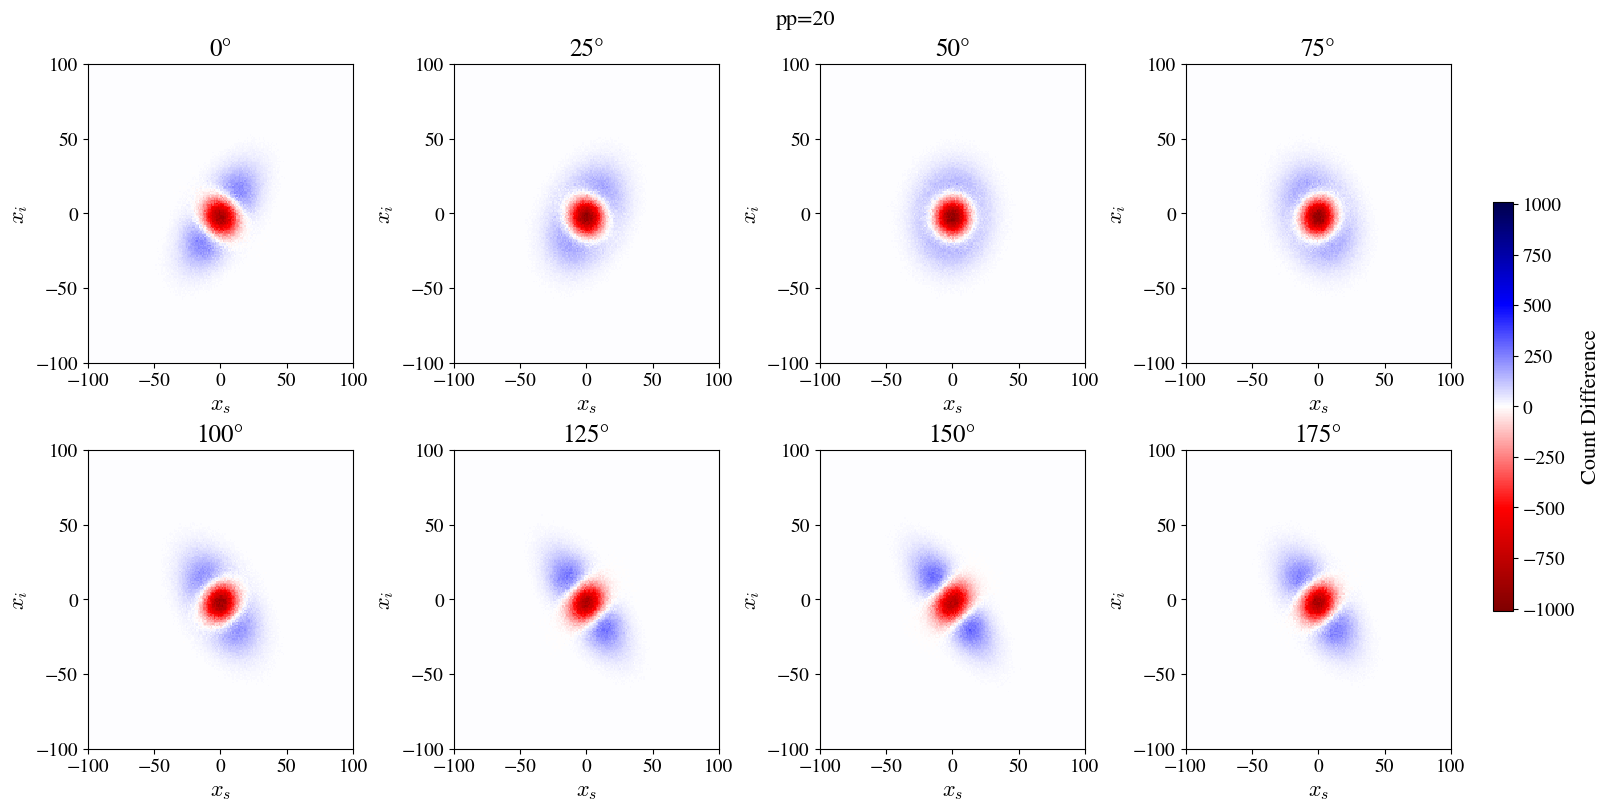

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os

# === Parameters ===
N = 40 * 20000
b = 200          # histogram bins
vrange = 100     # value range
s = s_vacuum            # scaling factor
phases = np.arange(0, 200, 25)
ncols = 4
nrows = int(np.ceil(len(phases) / ncols))

# === File templates ===
base_signal = "Idler/ch1_idler_data_fs=5.90000GHz_fi=6.55264GHz_fp=12.45264GHz_Pp=20_phase={:.1f}.dat"
base_idler  = "Signal/ch0_signal_data_fs=5.90000GHz_fi=6.55264GHz_fp=12.45264GHz_Pp=20_phase={:.1f}.dat"

# === Setup ===
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows), constrained_layout=True)
axes = axes.flatten()

all_diffs = []  # to track for vlim
meshes = []

for i, phase in enumerate(phases):
    try:
        signal_file = base_signal.format(phase)
        idler_file  = base_idler.format(phase)

        I0_on, Q0_on, I0_off, Q0_off = np.fromfile(signal_file).reshape(4, N)
        I1_on, Q1_on, I1_off, Q1_off = np.fromfile(idler_file).reshape(4, N)

        H_on, y_edges, x_edges = np.histogram2d(I1_on, I0_on * s, bins=b,
                                                range=[[-vrange, vrange], [-vrange, vrange]])
        H_off, _, _ = np.histogram2d(I1_off, I0_off * s, bins=b,
                                     range=[[-vrange, vrange], [-vrange, vrange]])
        diff = H_on - H_off
        all_diffs.append(diff)

    except FileNotFoundError:
        print(f"Warning: Missing file for phase {phase:.1f}° — skipped.")
        axes[i].axis("off")
        all_diffs.append(None)
        continue

# === Compute shared vlim ===
vlim = np.nanmax([np.abs(d).max() for d in all_diffs if d is not None])

# === Plot now with consistent colormap scale ===
for i, (phase, diff) in enumerate(zip(phases, all_diffs)):
    ax = axes[i]
    if diff is None:
        continue
    mesh = ax.pcolormesh(x_edges, y_edges, diff.T, cmap='seismic_r', shading='auto',
                         vmin=-vlim, vmax=+vlim)
    meshes.append(mesh)
    ax.set_title(f"{phase}°")
    ax.set_xlim(-vrange, vrange)
    ax.set_ylim(-vrange, vrange)
    ax.set_xlabel("$x_s$")
    ax.set_ylabel("$x_i$")

# === Add one shared colorbar ===
fig.colorbar(meshes[0], ax=axes, orientation='vertical', fraction=0.015, pad=0.02,
             label="Count Difference")

plt.suptitle("pp=20", fontsize=16)
plt.show()


### Visualizing Quadrature Pair Differences at Optimal Squeezing Phase

- This cell loads the time-domain data for the **signal** and **idler** modes at the previously determined *optimal squeezing phase*.

- It computes 2D histograms of various pairs of quadratures both when the pump is **on** and **off**, including:
  - $I_0$ vs $Q_0$ (signal in-phase and quadrature)
  - $I_1$ vs $Q_1$ (idler in-phase and quadrature)
  - $I_0$ vs $I_1$ (signal and idler in-phase)
  - $I_0$ vs $Q_1$ (signal in-phase vs idler quadrature)
  - $I_1$ vs $Q_0$ (idler in-phase vs signal quadrature)
  - $Q_0$ vs $Q_1$ (signal and idler quadratures)

- For each pair, it calculates the difference in histogram counts between pump **on** and **off** states to highlight how the distribution changes due to squeezing.

- The differences are plotted as 2D colormaps with a symmetric color scale centered at zero, using a diverging "seismic" colormap, enabling easy visualization of increases and decreases in counts.

- A shared colorbar indicates the magnitude of count differences across all subplots.

This visualization helps identify how the joint distributions of quadratures are modified at the squeezing angle, revealing correlations and squeezing signatures between the signal and idler modes.


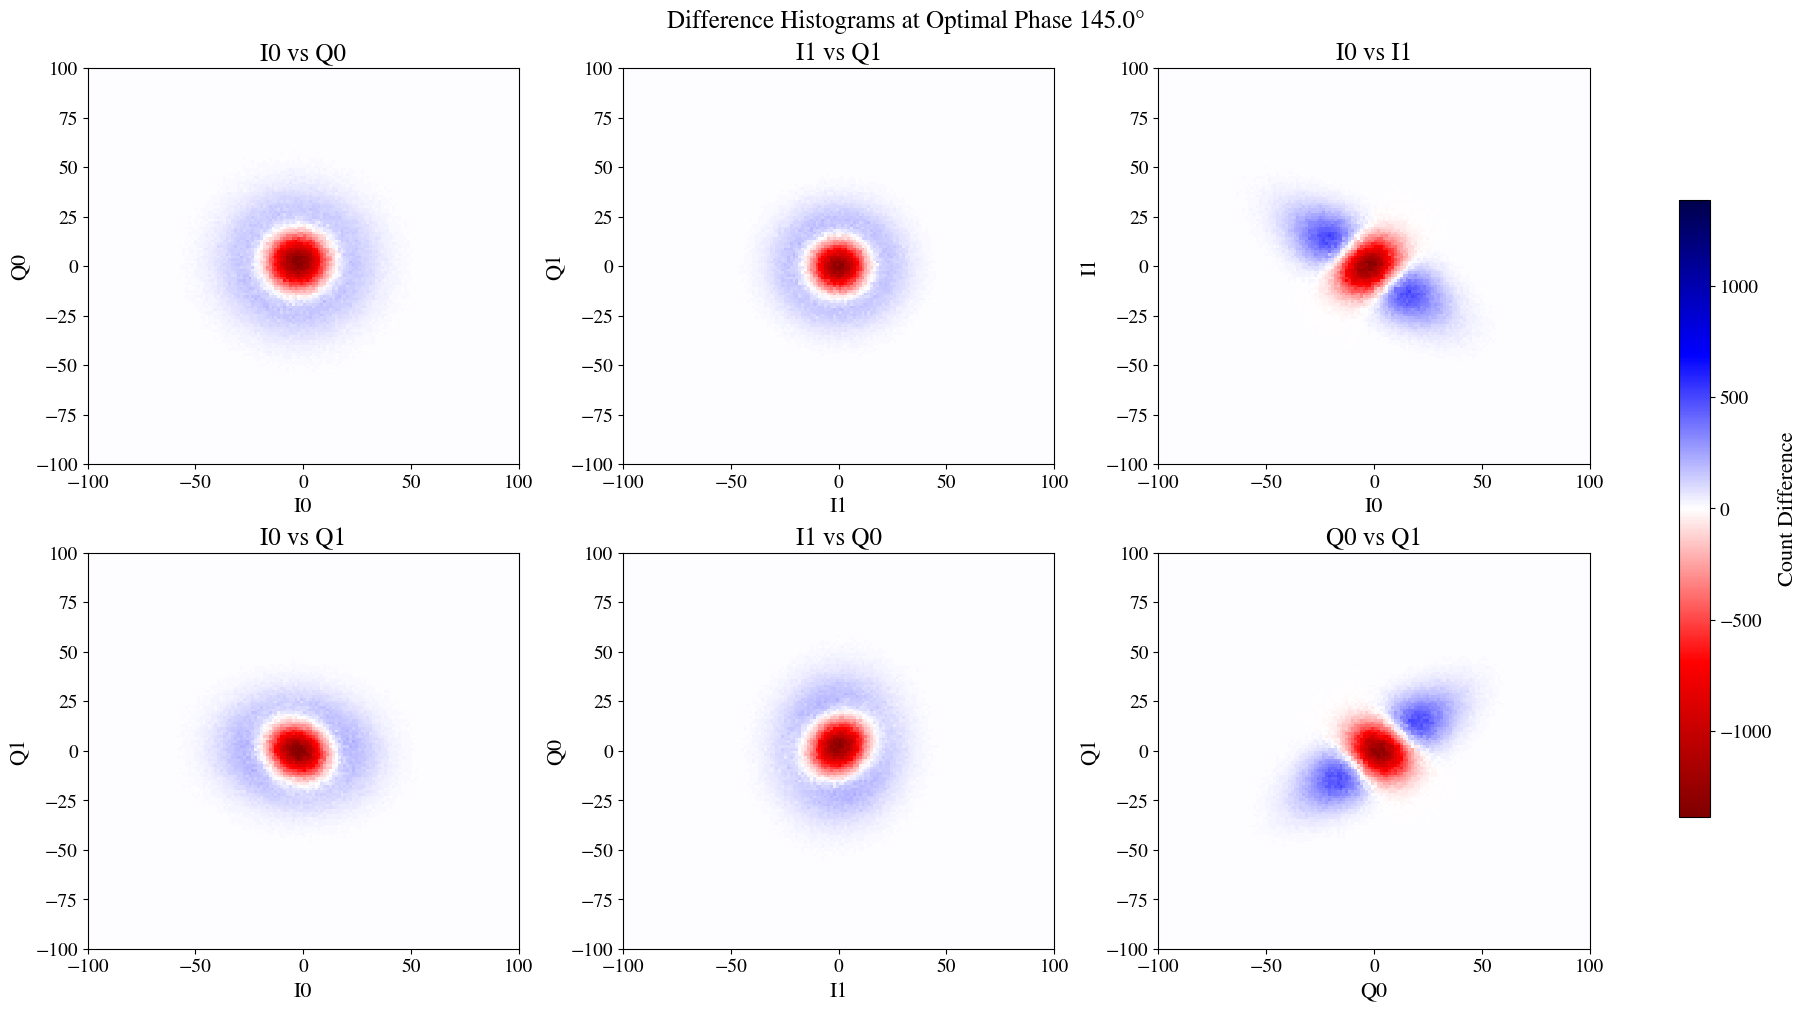

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# === Parameters ===
N = 40 * 20000
b = 150
vrange = 100
s = s_vacuum

# === Optimal phase previously determined ===
signal_file = f"Idler/ch1_idler_data_fs=5.90000GHz_fi=6.55264GHz_fp=12.45264GHz_Pp=20_phase={optimal_phase:.1f}.dat"
idler_file  = f"Signal/ch0_signal_data_fs=5.90000GHz_fi=6.55264GHz_fp=12.45264GHz_Pp=20_phase={optimal_phase:.1f}.dat"

# === Load data ===
I0_on, Q0_on, I0_off, Q0_off = np.fromfile(signal_file).reshape(4, N)
I1_on, Q1_on, I1_off, Q1_off = np.fromfile(idler_file).reshape(4, N)

# === Define pairings ===
pairs = [
    ("I0", I0_on, I0_off, "Q0", Q0_on, Q0_off),
    ("I1", I1_on, I1_off, "Q1", Q1_on, Q1_off),
    ("I0", I0_on, I0_off, "I1", I1_on, I1_off),
    ("I0", I0_on, I0_off, "Q1", Q1_on, Q1_off),
    ("I1", I1_on, I1_off, "Q0", Q0_on, Q0_off),
    ("Q0", Q0_on, Q0_off, "Q1", Q1_on, Q1_off),
]

# === Plotting ===
fig, axes = plt.subplots(2, 3, figsize=(18, 10), constrained_layout=True)
axes = axes.flatten()

for i, (xlab, x_on, x_off, ylab, y_on, y_off) in enumerate(pairs):
    ax = axes[i]

    # 2D histogram
    H_on, xedges, yedges = np.histogram2d(x_on, y_on, bins=b,
                                          range=[[-vrange, vrange], [-vrange, vrange]])
    H_off, _, _ = np.histogram2d(x_off, y_off, bins=b,
                                 range=[[-vrange, vrange], [-vrange, vrange]])

    # Avoid divide-by-zero
    with np.errstate(divide='ignore', invalid='ignore'):
        diff_percent = (H_on - H_off)
        diff_percent[np.isnan(diff_percent)] = 0

    # Center colorbar around zero
    vlim = np.nanmax(np.abs(diff_percent))

    mesh = ax.pcolormesh(xedges, yedges, diff_percent.T,
                         cmap='seismic_r', shading='auto',
                         vmin=-vlim, vmax=vlim)
    ax.set_title(f"{xlab} vs {ylab}")
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_xlim(-vrange, vrange)
    ax.set_ylim(-vrange, vrange)

# Add one shared colorbar
cbar = fig.colorbar(mesh, ax=axes, shrink=0.7, location='right')
cbar.set_label("Count Difference")

plt.suptitle(f"Difference Histograms at Optimal Phase {optimal_phase:.1f}°", fontsize=18)
plt.show()


# Understanding Covariance Matrices and Their Role in Quantum State Characterization

### 1. Gaussian Mixture Model (GMM) Mean

- The mean returned by a GMM fit represents the center (centroid) of the 2D Gaussian blob fitted to your data.
- This mean corresponds to the average position of your data points in the two-dimensional space (e.g., quadratures $x$ and $y$).
- You can subtract this mean from your data to **center** it around the origin for analysis.

---

### 2. Covariance Matrix Basics

For two variables $x$ and $y$, the covariance matrix is

$$
\text{Cov} =
\begin{pmatrix}
\mathrm{Var}(x) & \mathrm{Cov}(x, y) \\
\mathrm{Cov}(y, x) & \mathrm{Var}(y)
\end{pmatrix}
$$

- $\mathrm{Var}(x)$ is the variance of $x$, describing how much $x$ spreads around its mean.
- $\mathrm{Var}(y)$ is the variance of $y$.
- $\mathrm{Cov}(x, y)$ measures how $x$ and $y$ vary together — their correlation.

The covariance between two variables $X$ and $Y$ is defined as

$$
\mathrm{Cov}(X, Y) = \mathrm{Cov}(Y, X) = \mathbb{E} \big[(X - \mu_X)(Y - \mu_Y)\big]
$$

where $\mu_X$ and $\mu_Y$ are the means of $X$ and $Y$.

Because covariance is symmetric:

$$
\text{Cov} =
\begin{pmatrix}
\sigma_X^2 & c \\
c & \sigma_Y^2
\end{pmatrix}
$$

where $c = \mathrm{Cov}(X, Y)$.

---

### 3. Why Symmetry Matters

- The covariance matrix is always symmetric.
- This ensures the eigenvalues are **real numbers**.
- The eigenvectors (principal axes) are **orthogonal**, meaning the shape defined by the covariance matrix (an ellipse in 2D) has perpendicular principal axes.
- This is why you can rotate the coordinate system to align with these principal directions, which represent the natural axes of your data's spread.

---

### 4. Physical Interpretation in Quantum Measurement

- The covariance matrix describes the shape and orientation of the “data cloud” representing quadrature measurements.
- If the off-diagonal elements (covariances) are zero, then the principal axes align with your coordinate axes, and $x$ and $y$ are uncorrelated.
- Nonzero off-diagonal elements indicate correlations, meaning the cloud is tilted and the principal axes are rotated relative to the coordinate axes.

From the covariance matrix, by performing eigen decomposition:

- The **eigenvectors** give the directions of the principal axes — physically, directions of squeezing and anti-squeezing.
- The **square roots of the eigenvalues** give the standard deviations (noise levels) along those axes.

---

### 5. Context from the Roch Paper

> Starting from the measured quadratures $\mathbf{R} = (x_s, p_s, x_i, p_i)$, we estimate the covariance matrix $\sigma^{\mathrm{meas}}$ of the generated bipartite quantum state as
>
> $$
> \sigma_{jk}^{\mathrm{meas}} = 4 \left(\frac{1}{2} \langle R_j R_k + R_k R_j \rangle - \langle R_j \rangle \langle R_k \rangle \right),
> $$
>
> where the factor of 4 sets the vacuum state covariance matrix to the identity.
>
> The covariance matrix of the actual two-mode quantum state generated by the device (e.g., a TWPA) is inferred by subtracting the pump-off noise background:
>
> $$
> \sigma = \sigma^{\mathrm{meas,on}} - \sigma^{\mathrm{meas,off}} + \frac{1}{4} \mathbf{I},
> $$
>
> where $\mathbf{I}$ is the identity matrix, representing the two-mode vacuum noise.

---

### Summary

- The covariance matrix fully encodes the quantum noise and correlations in your measured quadratures.
- Diagonal terms: noise (variance) of each quadrature.
- Off-diagonal terms: correlations/entanglement between quadratures.
- Eigen-decomposition reveals squeezing directions and noise magnitudes along principal axes.
- The physical inference comes from comparing pump-on and pump-off states to isolate the quantum correlations produced by your device.

### Covariance Matrix and Quadrature Definitions in Continuous-Variable Quantum Optics

In continuous-variable quantum optics, the quadrature operators are commonly defined as:

$$
\hat{x} = \frac{1}{2} (\hat{a} + \hat{a}^\dagger), \quad \hat{p} = \frac{1}{2i} (\hat{a} - \hat{a}^\dagger)
$$

where $\hat{a}$ and $\hat{a}^\dagger$ are the annihilation and creation operators, respectively.

- Under this convention, the **vacuum state** (the ground state of the electromagnetic field) has variances:

$$
\mathrm{Var}(\hat{x}) = \mathrm{Var}(\hat{p}) = \frac{1}{2}
$$

---

However, in the **PRL paper (Phys. Rev. Lett. 128, 153603)** and in many experimental setups, the quadratures are defined *without* the factor of $\frac{1}{2}$:

$$
x = \hat{a} + \hat{a}^\dagger, \quad p = -i(\hat{a} - \hat{a}^\dagger)
$$

- Under this convention, the vacuum variances become:

$$
\mathrm{Var}(x) = \mathrm{Var}(p) = 1
$$

---

### Commutation Relations and Heisenberg Uncertainty

Given the relation:

$$
\hat{a} = \frac{1}{2} (x + i p) \implies [\hat{a}, \hat{a}^\dagger] = 1
$$

you can verify the canonical commutation relation:

$$
[x, p] = 2i
$$

This leads to the **Heisenberg uncertainty relation** in this normalization:

$$
\mathrm{Var}(x) \cdot \mathrm{Var}(p) \geq 1
$$

---

### Why the 0.25 (One-Fourth) Scaling in the Covariance Matrix?

In their method, the authors define the vacuum covariance matrix as:

$$
V_{\text{vacuum}} = \frac{1}{4} \cdot \mathbf{I}_4
$$

This corresponds to quadratures scaled such that:

$$
[x, p] = i \implies \mathrm{Var}(x) = \mathrm{Var}(p) = \frac{1}{2}
$$

- Here, $\mathbf{I}_4$ is the $4 \times 4$ identity matrix for the four quadratures $(x_s, p_s, x_i, p_i)$.

- Thus, the vacuum covariance matrix has diagonal entries **0.25** (i.e., $\frac{1}{4}$) for each quadrature variance.

---

### Context from the PRL Paper (Equation 4)

> "...the two-mode vacuum state covariance matrix corresponds to the unit matrix."

What they mean is:

$$
V_{\text{vac}} = \frac{1}{4} \cdot \mathbf{I}_4
$$

In practice, when calculating the **inferred covariance matrix**, they subtract the pump-off noise and add back this vacuum contribution:

$$
V_{\text{inferred}} = V_{\text{on}} - V_{\text{off}} + \frac{1}{4} \cdot \mathbf{I}_4
$$

---

### Summary and Intuition

- The factor $\frac{1}{4}$ appears because the paper uses a convention where the vacuum noise variance for each quadrature is 0.25, which corresponds to the canonical commutation relations scaled such that $[x, p] = i$.

- This normalization is convenient for comparing measured covariance matrices to the ideal vacuum noise level and for properly quantifying squeezing and entanglement.

- The addition of the vacuum covariance matrix $ \frac{1}{4} \mathbf{I}_4 $ after subtracting the off (pump-off) noise ensures that the inferred covariance matrix correctly reflects the physical quantum noise floor.

---

If you imagine the vacuum noise as the baseline "noise floor" at variance 0.25 per quadrature, your measured covariance matrices should be interpreted *relative* to this baseline for consistent quantum state characterization.



Scaling factor: 1.00000


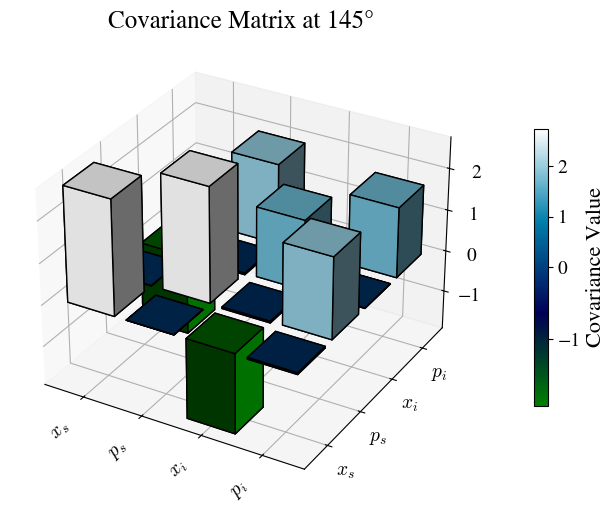

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import matplotlib.colors as mcolors

# === Your loaded data arrays ===
# I0_on, Q0_on, I0_off, Q0_off
# I1_on, Q1_on, I1_off, Q1_off

# Stack measured quadratures (shape 4 x N)
R_on = np.vstack([I0_on, Q0_on, I1_on, Q1_on])
R_off = np.vstack([I0_off, Q0_off, I1_off, Q1_off])

# === Compute scaling factor to normalize to vacuum ===
# Stack all pump-off quadrature arrays
vacuum_data = np.concatenate([I0_off, Q0_off, I1_off, Q1_off])

# Calculate the average variance across all vacuum quadratures
vacuum_variance = np.var(vacuum_data)

# Calculate scaling factor to bring var ≈ 0.25
scaling_factor = np.sqrt(0.25 / vacuum_variance)
print(f"Scaling factor: {scaling_factor:.5f}")

# === Apply scaling to all quadratures ===
I0_on  *= scaling_factor
Q0_on  *= scaling_factor
I1_on  *= scaling_factor
Q1_on  *= scaling_factor
I0_off *= scaling_factor
Q0_off *= scaling_factor
I1_off *= scaling_factor
Q1_off *= scaling_factor


# Compute covariance matrices (scaled by 4 as per PRL method)
cov_on = 4 * np.cov(R_on)
cov_off = 4 * np.cov(R_off)

# Inferred covariance matrix: Eq. (4) in the paper
cov_inferred = cov_on - cov_off + 0.25 * np.eye(4)

labels = ['$x_s$', '$p_s$', '$x_i$', '$p_i$']
N = len(labels)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

_x = np.arange(N)
_y = np.arange(N)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()
top = cov_inferred.ravel()
bottom = np.zeros_like(top)
width = depth = 0.8

# Colormap and normalization centered at 0 with `gist_earth`
cmap = plt.get_cmap('ocean')
vmin, vmax = np.min(top), np.max(top)
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
colors = cmap(norm(top))

# 3D bar plot
ax.bar3d(x, y, bottom, width, depth, top, color=colors, edgecolor='k', shade=True)
ax.set_zlim(np.min(top), np.max(top))


# Ticks and labels
ax.set_xticks(_x + width / 2)
ax.set_yticks(_y + depth / 2)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticklabels(labels)
#ax.set_zlabel("Covariance Value")
ax.set_title(f"Covariance Matrix at {optimal_phase}°")

# Colorbar — FIXED: specify ax
mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array(top)
cbar = plt.colorbar(mappable, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label("Covariance Value")

plt.show()


In [41]:
import numpy as np
from scipy.linalg import block_diag, eigvals

def symplectic_form(n_modes=2):
    """Returns the symplectic form Omega for n_modes."""
    omega = np.array([[0, 1], [-1, 0]])
    return block_diag(*([omega] * n_modes))

def partial_transpose_sigma(sigma, mode=1):
    """Apply partial transposition to the covariance matrix.
       mode=1: transpose second mode (idler)."""
    Lambda = np.eye(4)
    Lambda[2*mode+1, 2*mode+1] *= -1  # Flip sign of p of chosen mode
    return Lambda @ sigma @ Lambda

def symplectic_eigenvalues(sigma):
    """Compute the symplectic eigenvalues of a covariance matrix."""
    Omega = symplectic_form(n_modes=2)
    sigma_times_Omega = sigma @ Omega
    eigs = np.linalg.eigvals(1j * sigma_times_Omega)
    eigs = np.sort(np.abs(eigs))  # sort and ensure positivity
    # symplectic eigenvalues come in +/- pairs; we return positive half
    return eigs[:2]

def logarithmic_negativity(cov_matrix):
    """Compute logarithmic negativity from a 4x4 covariance matrix."""
    sigma_pt = partial_transpose_sigma(cov_matrix, mode=1)  # partial transpose idler
    nu_tilde = symplectic_eigenvalues(sigma_pt)
    # Only the smallest symplectic eigenvalue contributes
    smallest_nu = np.min(nu_tilde)
    if smallest_nu >= 0.5:
        return 0.0
    else:
        return -np.log2(2 * smallest_nu)

# === Run it on your inferred covariance matrix ===
E_N = logarithmic_negativity(cov_inferred)
print(f"Logarithmic Negativity: {E_N:.4f}")


Logarithmic Negativity: 1.2633


In [42]:
sigma_pt = partial_transpose_sigma(cov_inferred)
nu_tilde = symplectic_eigenvalues(sigma_pt)
print("Symplectic eigenvalues after partial transpose:", nu_tilde)


Symplectic eigenvalues after partial transpose: [0.20829951 0.20829951]


In [43]:
print("Diagonal of inferred covariance matrix:", np.diag(cov_inferred))


Diagonal of inferred covariance matrix: [2.45672817 2.45710004 1.50637517 1.51225622]


### Interpretation of Results

- **Logarithmic Negativity  
  This is a widely used quantitative measure of entanglement for continuous-variable systems like two-mode squeezed states.  
  - A **positive value** indicates entanglement.  
  - Larger values correspond to stronger entanglement.  
  In the paper (Phys. Rev. Lett. 128, 153603), they use logarithmic negativity to characterize how “quantum” the generated state is, showing how the TWPA produces entangled photon pairs.

- **Symplectic Eigenvalues after Partial Transpose:**  
  These eigenvalues come from the covariance matrix after applying a partial transpose operation (a mathematical operation related to the Peres-Horodecki criterion for entanglement).  
  - For Gaussian states, **if any symplectic eigenvalue is less than 0.5**, the state is entangled.  
  - Values $< 0.5$ **confirm the presence of entanglement** in the bipartite quantum state measured.  
  - When the two eigenvalues are nearly equal suggests the system is approximately symmetric between the two modes (signal and idler), which matches the ideal two-mode squeezed vacuum model.

- **Diagonal Elements of the Covariance Matrix:**  
  The covariance matrix encodes variances and correlations of your quadrature measurements:  
  - The diagonal terms represent the **variance of each quadrature** ($x_s$, $p_s$, $x_i$, $p_i$).  
  - In the normalization scheme used (vacuum noise corresponds to 0.25), values greater than 0.25 indicate that the quadratures are no longer vacuum fluctuations — they have been amplified or squeezed by the device.  
  - These variances reflect the physical noise and squeezing levels in your measurement, consistent with expectations from the paper’s setup.  
  - Slight differences between them may be due to measurement imperfections or asymmetries in the device.

---

### Additional explanation on the covariance matrix and entanglement:

- The covariance matrix is a **complete description of Gaussian quantum states** (which the two-mode squeezed states are). It tells us how each quadrature varies individually (diagonal elements) and how quadratures of different modes correlate (off-diagonal elements).

- The **partial transpose operation** corresponds physically to a kind of time reversal on one mode and is used as a test for entanglement. If after this operation, the covariance matrix violates the Heisenberg uncertainty principle (which manifests as a symplectic eigenvalue dropping below 0.5), this is a direct signature of entanglement.

- **Logarithmic negativity** is then a convenient scalar measure derived from these symplectic eigenvalues, providing a way to quantify "how entangled" the state is.
